In [ ]:
pip install transformers==4.45.2 sentence-transformers==3.1.1 datasets evaluate

In [90]:
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score, f1_score,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    classification_report
)
from imblearn.over_sampling import RandomOverSampler
from peft import PeftModel, LoraConfig, get_peft_model
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.nn import functional as F
from imblearn.over_sampling import SMOTE


In [ ]:
companies = pd.read_csv('companies.csv')
companies

In [33]:
# define success variable
companies['Success'] = ((companies['Was Acquired'] == 1) |
                   (companies['IPO'] == 1) |
                   (companies['High Funding'] == 1)).astype(int)

# concat columns that were exploded for classical ML algos
def concatenate_columns(df, column_prefix, new_column_name):
    columns_to_combine = [col for col in df.columns if col.startswith(column_prefix)]

    def concatenate_values(row, cols):
        values = [col.replace(column_prefix, '') for col in cols if row[col] == 1]
        return ', '.join(values)

    df[new_column_name] = df.apply(lambda row: concatenate_values(row, columns_to_combine), axis=1)
    df = df.drop(columns=columns_to_combine)

    return df


companies = concatenate_columns(companies, column_prefix='Industry_', new_column_name='Industry')
companies = concatenate_columns(companies, column_prefix='Investor Country_', new_column_name='Investor Country')


# fill all 0 values with NaN to sort out non existent data when initializing prompts
companies = companies.replace(0, np.nan)
companies['Success'] = companies['Success'].fillna(0)

8485


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


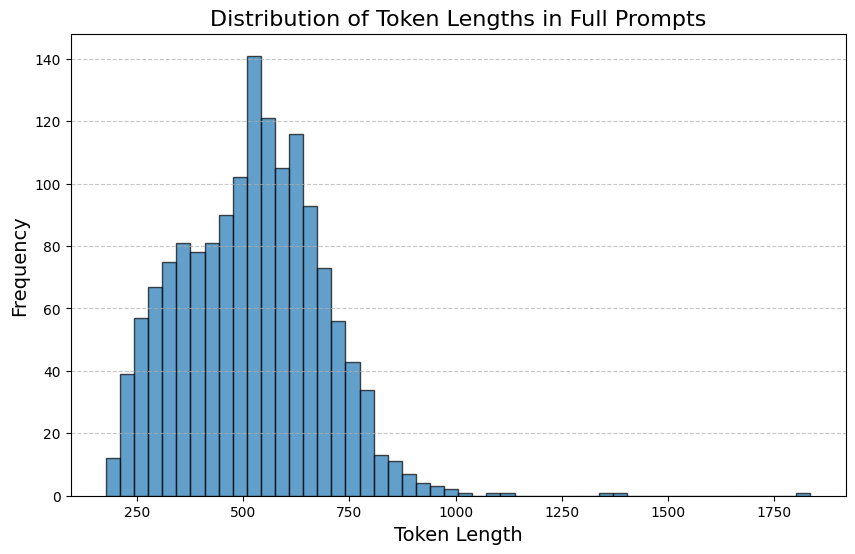

In [104]:
# load model & tokenizer
model_id = "distilbert/distilbert-base-uncased"
id2label = {0: "No-Success", 1: "Success"}
label2id = {"No-Success": 0, "Success": 1}

tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2, id2label=id2label, label2id=label2id
    )

# generate prompt pairings for training, exclude columns that we deem irrelevant or are included in the resulting label
excluded_cols = ['Was Acquired', 'IPO', 'HighFunding', 'Success', 'Description', 'LinkedIn', 'Twitter', 'ID', 'Website',
                 'Project Funding', 'Startup Funding', 'Growth Funding', 'Expansion Funding', 'Exit Funding', 'Company ID',
                 'Facebook', 'Industry']

full_prompts = []
for _, row in companies.iterrows():
    eligible_cols = [col for col in companies.columns if col not in excluded_cols]
    details = [f"{col}: {row[col]}" for col in eligible_cols if pd.notna(row[col])]
    input_text = "Company Details: " + "; ".join(details) + ". Predict Success"
    full_prompts.append({"text": input_text.replace("\n", ""), "label": int(row['Success'])})

full_prompts = pd.DataFrame(full_prompts)

# evaluate length of prompts in tokens to adjust for majority of data when training, we deem 1024 tokens as acceptable, truncating a very small part of the dataset 
token_lengths = full_prompts['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Token Lengths in Full Prompts", fontsize=16)
plt.xlabel("Token Length", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# resize max accepted tokens by model
def resize_max_embeddings(model, new_max_position_embeddings):
    old_max_position_embeddings = model.config.max_position_embeddings

    if new_max_position_embeddings > old_max_position_embeddings:
        model.config.max_position_embeddings = new_max_position_embeddings

        old_position_embeddings = model.base_model.embeddings.position_embeddings
        new_position_embeddings = torch.nn.Embedding(new_max_position_embeddings, old_position_embeddings.embedding_dim)

        new_position_embeddings.weight.data[:old_max_position_embeddings] = old_position_embeddings.weight.data

        new_position_embeddings.weight.data[old_max_position_embeddings:] = torch.nn.init.normal_(
            torch.empty(new_max_position_embeddings - old_max_position_embeddings, old_position_embeddings.embedding_dim)
        )

        model.base_model.embeddings.position_embeddings = new_position_embeddings
        model.base_model.embeddings.position_ids = torch.arange(new_max_position_embeddings).expand((1, -1))

resize_max_embeddings(model, 1024)


In [118]:
# Split dataset into train and test
train, test = train_test_split(full_prompts, test_size=0.4, stratify=full_prompts["label"], random_state = 42)

# for later results
input_text = test["text"]

# Tokenize the training texts
X_train = train['text'].tolist()
y_train = train['label'].tolist()

tokenized_train = tokenizer(
    X_train,
    truncation=True,
    padding="max_length",
    max_length=750,
    return_tensors="np"
)

input_ids = tokenized_train['input_ids']
attention_mask = tokenized_train['attention_mask']

# Combine tokenized training prompts and labels for SMOTE sampling to manage class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(input_ids, y_train)

# Align attention_mask with resampled input_ids
attention_mask_resampled = attention_mask[X_resampled[:, 0]]  # Use resampled indices from SMOTE

train_balanced = {
    "input_ids": X_resampled,
    "attention_mask": attention_mask_resampled,
    "label": y_resampled
}

# Convert to Hugging Face Dataset for taining process
train_dataset = Dataset.from_dict(train_balanced)

# Tokenize test dataset
tokenized_test = tokenizer(
    test['text'].tolist(),
    truncation=True,
    padding="max_length",
    max_length=750,
    return_tensors="np"
)

test_dataset = Dataset.from_dict({
    "input_ids": tokenized_test['input_ids'],
    "attention_mask": tokenized_test['attention_mask'],
    "label": test['label'].tolist()
})


# Data collator to dynamically pad data during training on batch level 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [119]:
# Define LoRA configuration dynamically for grid search
def create_peft_model(base_model, r, lora_alpha, lora_dropout):
    peft_config = LoraConfig(
        task_type="SEQ_CLS",
        r=r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=["q_lin"],
    )
    return get_peft_model(base_model, peft_config)

# Define the grid search space (we used a very small search space in order to have reasonable computing time while still getting an indication on how hyperparameters affect the model)
search_space = {
    "learning_rate": [1e-3],
    "per_device_train_batch_size": [16],
    "r": [16],
    "lora_alpha": [16],
    "lora_dropout": [0.2]
}

# Define main evaluation metric used 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, predictions, average="weighted")}

# Perform grid search
def grid_search():
    global best_trainer, best_predictions, best_labels, trainer
    best_f1 = 0
    best_hyperparams = None
    best_trainer = None
    best_predictions = None
    best_labels = None

    for lr in search_space["learning_rate"]:
        for batch_size in search_space["per_device_train_batch_size"]:
            for r in search_space["r"]:
                for lora_alpha in search_space["lora_alpha"]:
                    for lora_dropout in search_space["lora_dropout"]:
                        # Current hyperparameter combination
                        hyperparams = {
                            "learning_rate": lr,
                            "per_device_train_batch_size": batch_size,
                            "r": r,
                            "lora_alpha": lora_alpha,
                            "lora_dropout": lora_dropout
                        }

                        print(f"Testing hyperparameters: {hyperparams}")

                        # Initialize model with LoRA
                        model_with_peft = create_peft_model(
                            model,
                            r=hyperparams["r"],
                            lora_alpha=hyperparams["lora_alpha"],
                            lora_dropout=hyperparams["lora_dropout"]
                        )

                        # TrainingArguments
                        training_args = TrainingArguments(
                            output_dir="./grid-search-results",
                            evaluation_strategy="epoch",
                            save_strategy="epoch",
                            load_best_model_at_end=True,
                            metric_for_best_model="f1",
                            greater_is_better=True,
                            num_train_epochs=5,
                            weight_decay=0.1,
                            logging_dir="./logs",
                            report_to="none",
                            learning_rate=lr,
                            per_device_train_batch_size=batch_size,
                            per_device_eval_batch_size=batch_size
                        )

                        # Re-initialize Trainer
                        trainer = Trainer(
                            model=model_with_peft,
                            args=training_args,
                            train_dataset=train_dataset,
                            eval_dataset=test_dataset,
                            tokenizer=tokenizer,
                            data_collator=data_collator,
                            compute_metrics=compute_metrics,
                        )

                        # Train and evaluate
                        trainer.train()
                        eval_results = trainer.evaluate()
                        current_f1 = eval_results["eval_f1"]

                        print(f"F1 Score for {hyperparams}: {current_f1}")

                        # Track the best hyperparameters
                        if current_f1 > best_f1:
                            best_f1 = current_f1
                            best_hyperparams = hyperparams
                            best_trainer = trainer

    print(f"Best F1 Score: {best_f1}")
    print(f"Best Hyperparameters: {best_hyperparams}")

grid_search()


Testing hyperparameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 16, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.877742,0.726892
2,No log,0.370156,0.852376
3,No log,0.282856,0.882231
4,No log,0.252552,0.893233
5,No log,0.246364,0.897635


F1 Score for {'learning_rate': 0.001, 'per_device_train_batch_size': 16, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2}: 0.8976347649025143
Best F1 Score: 0.8976347649025143
Best Hyperparameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 16, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2}


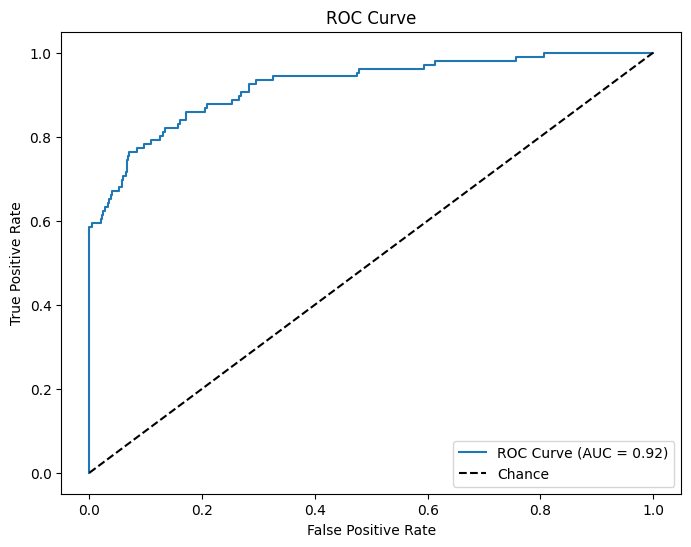

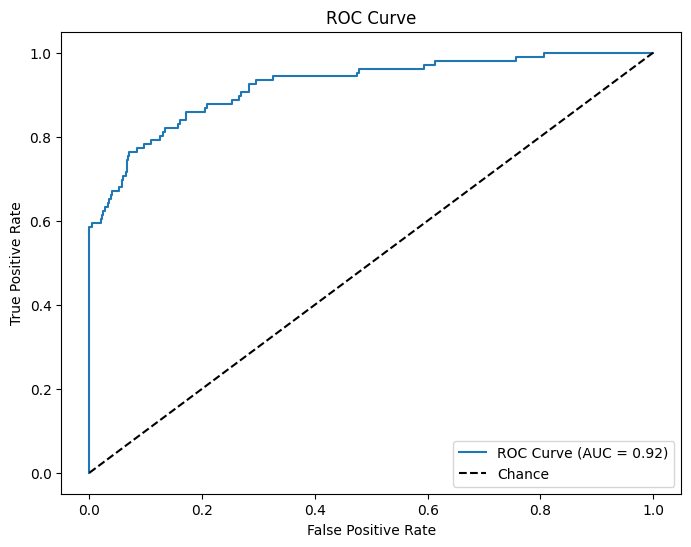

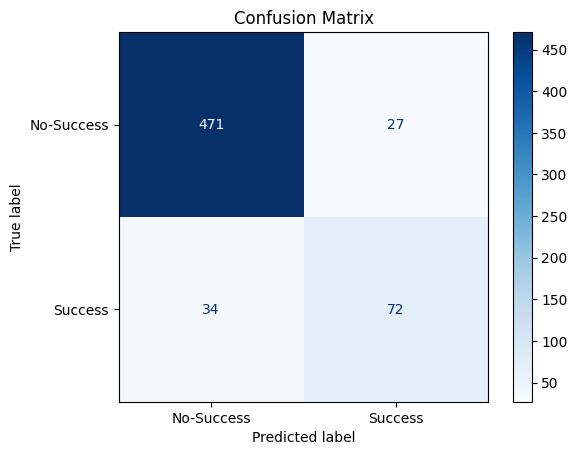

In [120]:
# Visualization of results in terms of ROC curve and a confusion matrix to directly see the decisions of the model 
def plot_roc(labels, predictions):
    """Plot ROC curve for evaluation."""
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_cm(labels, predictions):
    """Display confusion matrix."""
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No-Success", "Success"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


raw_predictions = best_trainer.predict(test_dataset)
y_probs = torch.nn.functional.softmax(torch.tensor(raw_predictions.predictions), dim=1)[:, 1].numpy()
labels = raw_predictions.label_ids
predictions = np.argmax(raw_predictions.predictions, axis=1)



plot_roc(labels, y_probs)
plot_cm(labels, predictions)

In [121]:
# save the predictions to csv
results = pd.DataFrame(
    {
        'input_text': input_text,
        'predictions': predictions.tolist(),
        'labels': labels.tolist(),
        'y_probs': y_probs.tolist()
    }
)

# results.to_csv('tunedLLM_predictions.csv', index=False)